INSTALLATIONS

In [1]:
!pip install sentence-transformers torch pandas scikit-learn
!pip install datasets
!pip install sentence-transformers==2.2.0
!pip install transformers==4.22.0
!pip install --upgrade huggingface_hub
!pip install --upgrade sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformer

In [2]:
import wandb
wandb.init(mode="disabled")


NECESSARY IMPORTS

In [3]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import re




MODEL INITIALIZATION

In [4]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

USING THE TRAINED MODEL

In [5]:
from google.colab import drive
drive.mount('/content/drive')


model = SentenceTransformer('/content/drive/MyDrive/job_skills_model')
skill_embeddings = torch.load('/content/drive/MyDrive/skill_embeddings.pt')

Mounted at /content/drive


<ipython-input-5-022fc79cabc2>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  skill_embeddings = torch.load('/content/drive/MyDrive/skill_embeddings.pt')


In [6]:
# Load unique skills
with open('/content/drive/MyDrive/unique_skills.txt', 'r') as f:
    unique_skills = [line.strip() for line in f]

NORMALIZING SKILLS

In [7]:
SYNONYM_MAP = {
    "qa": "Quality Assurance",
    "quality assurance": "Quality Assurance",
    "software quality assurance": "quality assurance",
    "sqa": "quality assurance",
    "sdlc": "software development lifecycle",
    "software development lifecycle":"software development lifecycle",
    "bdd": "behavior driven development",
    "tdd": "test driven development",
    "oop": "object-oriented programming",
    # will add further
}


def normalize_skill(skill):
    skill = skill.lower().strip()
    if skill in SYNONYM_MAP:
        skill = SYNONYM_MAP[skill]
    skill = re.sub(r"[^\w\s]", "", skill).replace("  ", " ")
    skill = skill.replace(" js", "").replace("js", "")
    skill = skill.replace(",", "").replace("-", "").replace(".", "").replace(" ", "")
    return skill



SKILLS PREDICTIONS

In [37]:
def predict_skills(job_title, model, skill_embeddings, unique_skills, top_n=20):
    job_embedding = model.encode(job_title, convert_to_tensor=True)
    similarities = cosine_similarity(
        job_embedding.unsqueeze(0).detach().numpy(),
        skill_embeddings.detach().numpy()
    )[0]
    top_indices = np.argsort(similarities)[::-1]
    seen_skills = set()
    top_skills_with_scores = []

    for i in top_indices:
        raw_skill = unique_skills[i].strip()
        normalized_skill = normalize_skill(raw_skill)

        if normalized_skill not in seen_skills:
            seen_skills.add(normalized_skill)
            top_skills_with_scores.append((raw_skill, similarities[i]))
        if len(top_skills_with_scores) == top_n:
            break
    top_skills_with_scores.sort(key=lambda x: x[1], reverse=True)
    top_skills = [skill for skill, _ in top_skills_with_scores]
    top_skills = [re.sub(r"[^\w\s]", "", unique_skills[i].strip()) for i in top_indices if unique_skills[i] in top_skills]

    return ', '.join(top_skills)


SEMANTIC SKILLS MATCHING

In [38]:
def calculate_skill_match_percentage(predicted_skills, actual_skills, model):

    predicted_embeddings = model.encode(predicted_skills.split(', '), convert_to_tensor=True)
    actual_embeddings = model.encode(actual_skills, convert_to_tensor=True)

   #calculation cosine similarity in pairs with each skills paired with each
    similarity_matrix = cosine_similarity(
        predicted_embeddings.detach().numpy(),
        actual_embeddings.detach().numpy()
    )


    similarity_threshold = 0.85  # this value is high to avoid overmatching
    matched_actual_skills = set()

    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i, j] >= similarity_threshold:
                matched_actual_skills.add(j)


    matched_count = len(matched_actual_skills)

    total_actual_skills = len(actual_skills)
    if total_actual_skills == 0:
        return 0


    match_percentage = (matched_count / total_actual_skills) * 100
    return match_percentage


TESTING THE MODEL ON TEST DATA

In [39]:

def test_model_on_dataset(test_data, model, skill_embeddings, unique_skills, top_n=20):
    results = []

    for _, row in test_data.iterrows():
        job_title = row['Job Title']
        actual_skills = row['Skills'].split(', ')
        predicted_skills = predict_skills(job_title, model, skill_embeddings, unique_skills, top_n)

        match_percentage = calculate_skill_match_percentage(predicted_skills, actual_skills, model)

        results.append({
            'Job Title': job_title,
            'Actual Skills': ', '.join(actual_skills),
            'Predicted Skills': predicted_skills,

            'Match Percentage': match_percentage
        })

    return results

RESULTS

In [40]:

test_data = pd.read_csv('/content/TestingData.csv', encoding='ISO-8859-1')
test_data.columns = test_data.columns.str.strip()

top_n = 100
results = test_model_on_dataset(test_data, model, skill_embeddings, unique_skills, top_n=top_n)


for result in results:
    print(f"Job Title: {result['Job Title']}")
    print(f"Actual Skills: {result['Actual Skills']}")
    print(f"Predicted Skills: {result['Predicted Skills']}")
    print(f"Match Percentage: {result['Match Percentage']:.2f}%\n")


results_df = pd.DataFrame(results)
results_df.to_csv('/content/TestingDataResults_top_n.csv', index=False)

Job Title: Software Quality Assurance Engineer 
Actual Skills: Concepts of QC, QA methodologies, Testing Tools, Test types, Test Documents, Mobile Apps, API testing, Selenium, Cypress, TestNG, JUnit, Python, Java, JavaScript, Git, JMeter, LoadRunner, Postman, SoapUI
Predicted Skills: software quality assurance, qa, software development lifecycle, qa methodologies, defect tracking, product testing, system testing, quality assurance qa, testing methodologies, qa standards, test case design, test cases, test automation, automation testing, feature testing, software principles, code testing, test strategies, software development, web testing, defect reporting, api testing, automated testing, defect analysis, acceptance testing, qa principles, qa testing, test strategy, test scenarios, test planning, datadriven testing, regression testing, testing documentation, performance testing, web applications testing, testing frameworks, software development lifecycle sdlc, software development princ

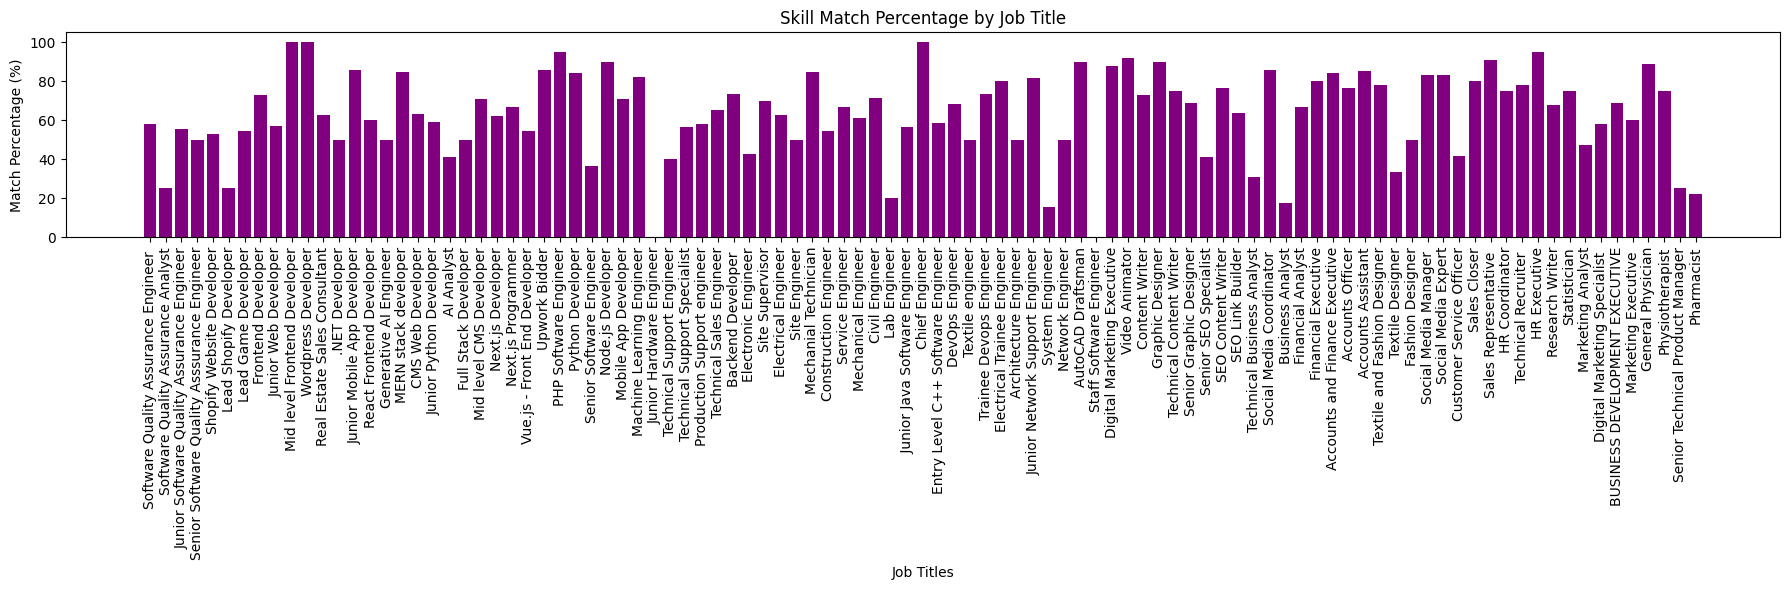

In [42]:
import matplotlib.pyplot as plt

def plot_match_percentages(results):
    job_titles = [result['Job Title'] for result in results]
    match_percentages = [result['Match Percentage'] for result in results]

    plt.figure(figsize=(18, 6))
    plt.bar(job_titles, match_percentages, color='purple')
    plt.xlabel('Job Titles')
    plt.ylabel('Match Percentage (%)')
    plt.title('Skill Match Percentage by Job Title')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_match_percentages(results)


FOR ASTHETICS PURPOSES ONLY

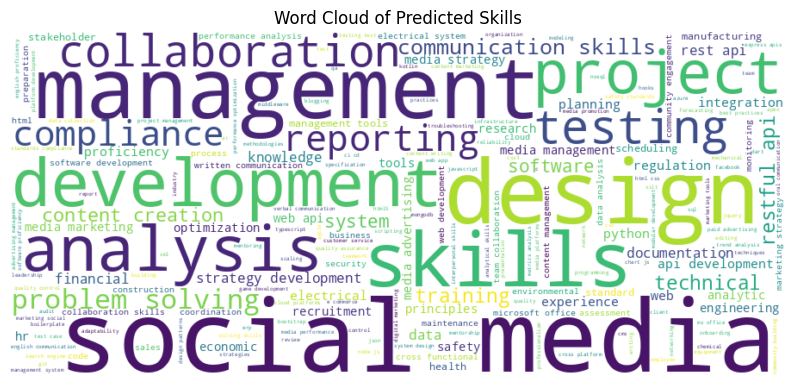

In [36]:
from wordcloud import WordCloud

def plot_predicted_skills_wordcloud(results):
    all_predicted_skills = ', '.join(result['Predicted Skills'] for result in results)
    wordcloud = WordCloud(width=900, height=400, background_color='white').generate(all_predicted_skills)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Predicted Skills')
    plt.show()

plot_predicted_skills_wordcloud(results)
